In [2]:
import os
import cv2
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from skimage.io import imread, imshow
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from keras_preprocessing.image import img_to_array, array_to_img, load_img, ImageDataGenerator

2023-01-27 15:27:47.037627: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Below are a number of helper functions that are used in the main code

In [3]:
#Data loader function, slightly rewritten to work with lbp calculations
def get_data(df, imgloc):
    data = []
    for i in df['ogfilename']:
        img = load_img(imgloc+i)
        x = img_to_array(img)
        x = x/255
        if img.size > (224,224) or img.size < (244,244):
            x = tf.image.resize_with_pad(x, 224, 224, method="nearest")
            x = x.numpy() #Needed for LBP
            data.append(x)
        else:
            x = x.numpy()
            data.append(x)
    return np.asarray(data)

In [4]:
#Vectorised lbp calculator, rewritten to work with float32, as used by tf image resizing
def lbp_calculated_pixel(img):
    #Get center pixel value
    center = img[1:-1,1:-1]
    #Create an array to stor lbp values
    lbp_val = np.zeros_like(center)
    #Compare the center value to its neighbours. The lbp_val array is then filled with binary numbers depending on the comparison
    lbp_val = np.where(img[0:-2,0:-2] > center, 1, 0)
    lbp_val += np.where(img[0:-2,1:-1] > center, 2, 0)
    lbp_val += np.where(img[0:-2,2:] > center, 4, 0)
    lbp_val += np.where(img[1:-1,2:] > center, 8, 0)
    lbp_val += np.where(img[2:,2:] > center, 16, 0)
    lbp_val += np.where(img[2:,1:-1] > center, 32, 0)
    lbp_val += np.where(img[2:,0:-2] > center, 64, 0)
    lbp_val += np.where(img[1:-1,0:-2] > center, 128, 0)
    return lbp_val

In [5]:
#Helper funcion to apply the lbp to all images in a dataset
def apply_lbp(data):
    lbp_applied = []
    for img in data:
        img_lbp = lbp_calculated_pixel(img)
        lbp_applied.append(img_lbp)
    return np.array(lbp_applied)

In [6]:
#Helper function that turns lbp codes into individual histograms
def create_lbp_hist(arr):
    ind_hist = []
    for i in range(arr.shape[0]):
        hist = np.histogram(arr[i], bins=256, range=(0, 255))[0]
        ind_hist.append(hist)
    return ind_hist

In [7]:
#Helper function that normalises histograms by dividing each bin by the total number of pixels in the image
def norm_hist(arr):
    norm = []
    for hist in arr:
        n_hist = hist / np.sum(hist)
        norm.append(n_hist)
    return norm

In [8]:
#Labelling function
def label(df):
    df["label"] = np.nan
    df.loc[df["type"] == "No Pneumonia", 'label'] = "A"
    df.loc[df["type"] == "Bacterial Pneumonia", 'label'] = "B"
#     df.loc[df["type"] == "Fungal Pneumonia", 'label'] = "C"
    df.loc[df["type"] == "Viral Pneumonia", 'label'] = "D"
    df.loc[df["Covid"] == True, 'label'] = "C"
#     df.loc[df["type"] == "Undefined Pneumonia", 'label'] = "F"
    return df

In [9]:
#Function to remove unwanted entries and images
def rem_masks(df, data):
    fungal_mask = (df['type'] == 'Fungal Pneumonia')
    un_mask = (df['type'] == 'Undefined Pneumonia')
    nan_mask = df['type'].isna()

    # Get the index of rows with the specific condition
    fungal_index = np.array(df.loc[fungal_mask].index)
    un_index = np.array(df.loc[un_mask].index)
    nan_index = np.array(df.loc[nan_mask].index)

    rem_index = np.sort(np.concatenate((fungal_index,un_index,nan_index)))

    df = df.drop(rem_index)
    data = np.delete(data, rem_index, axis=0)
    return df, data

In [10]:
#Helper function that creates SVMs. As mentioned below, C=1000 and gamma=1 were previously found using Gridsearch
def create_svm(x_train, y_train):
    model = svm.SVC(C=1000, gamma=1)
    model.fit(x_train, y_train)
    return model

In [11]:
#Helper function that displays confusion matrix and classification report for svm models
def show_metrics(model, x_test, y_test):
    pred = model.predict(x_test)
    cm = confusion_matrix(y_test, pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()
    print(classification_report(y_test, pred))

Below is the main code that handles the data to svm pipeline

In [12]:
#Loading Data Here
ziploc="/Users/lennardbornemann/PatternRec/groupProj/Final/"
all_img_loc="/Users/lennardbornemann/PatternRec/groupProj/Final/All_Img/"

og_train_zf = zipfile.ZipFile(ziploc+'train_data.zip') 
og_train_df = pd.read_csv(og_train_zf.open('train_data.csv'))

testzip = zipfile.ZipFile(ziploc+'test_final.zip') 
test_df = pd.read_csv(testzip.open('test_final.csv'))

aug_trainzip = zipfile.ZipFile(ziploc+'train_final.zip') 
aug_train_df = pd.read_csv(aug_trainzip.open('train_final.csv'))

In [13]:
#Label the data - Only needed for original train. Test and augmented is already labeled correctly
#Original train
og_train_df = label(og_train_df)

In [14]:
#Resize original images only. np.uint8 to avoid problems with lbp
og_train_data = get_data(og_train_df, all_img_loc)
test_data = get_data(test_df, all_img_loc)
aug_train_data = get_data(aug_train_df, all_img_loc)

2023-01-27 15:28:04.350261: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
#Remove unwanted images and entries - Only for original train data
og_train_df, og_train_data = rem_masks(og_train_df, og_train_data)

In [16]:
#Apply lbp to images
og_train_lbp = apply_lbp(og_train_data)
test_lbp = apply_lbp(test_data)
aug_train_lbp = apply_lbp(aug_train_data)

In [17]:
#Convert lbp codes to histograms
og_train_hist = create_lbp_hist(og_train_lbp)
test_hist = create_lbp_hist(test_lbp)
aug_train_hist = create_lbp_hist(aug_train_lbp)

In [18]:
#Normalise lbp histograms
og_train_norm = norm_hist(og_train_hist)
test_norm = norm_hist(test_hist)
aug_train_norm = norm_hist(aug_train_hist)

Previous GridsearchCV and RandomisedSearchCV gave C:1000, gamma:1 as the best parameters, so those will be used to avoid running Gridsearch each time.

In [20]:
#Create svm models
#Original train and original test
og_train_test_model = create_svm(og_train_norm, og_train_df['label'])

#Augmented train and original test
aug_train_test_model = create_svm(aug_train_norm, aug_train_df['label'])

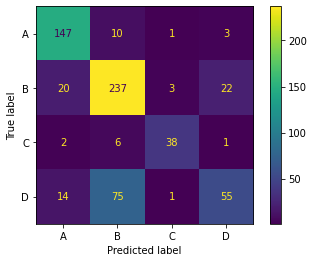

              precision    recall  f1-score   support

           A       0.80      0.91      0.85       161
           B       0.72      0.84      0.78       282
           C       0.88      0.81      0.84        47
           D       0.68      0.38      0.49       145

    accuracy                           0.75       635
   macro avg       0.77      0.74      0.74       635
weighted avg       0.75      0.75      0.74       635



In [21]:
show_metrics(og_train_test_model, test_norm, test_df['label'])

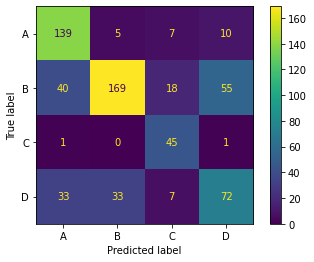

              precision    recall  f1-score   support

           A       0.65      0.86      0.74       161
           B       0.82      0.60      0.69       282
           C       0.58      0.96      0.73        47
           D       0.52      0.50      0.51       145

    accuracy                           0.67       635
   macro avg       0.64      0.73      0.67       635
weighted avg       0.69      0.67      0.67       635



In [22]:
show_metrics(aug_train_test_model, test_norm, test_df['label'])